<a href="https://colab.research.google.com/github/sashkoangelov/NLP_final_project/blob/main/NLP_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports

In [1]:
%%capture

!pip install transformers datasets
!pip install datasets
!pip install pyngrok

In [2]:
pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-fw1c28q_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-fw1c28q_
  Resolved https://github.com/huggingface/accelerate to commit 4d415f2129f97da4b16f29b9bf0535fe5f2fb0e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [20]:
import pandas as pd
import torch
import random
import accelerate
import transformers
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, RobertaTokenizerFast, RobertaForQuestionAnswering, TrainingArguments, Trainer, default_data_collator
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset, load_dataset, load_metric
from pyngrok import ngrok
from torch.utils.tensorboard import SummaryWriter
import os

In [4]:
print(transformers.__version__)

4.38.2


#Data loading

In [5]:
train = pd.read_parquet("/content/drive/MyDrive/NLP/train-00000-of-00001.parquet")
validation = pd.read_parquet("/content/drive/MyDrive/NLP/validation-00000-of-00001.parquet")

## Displaying random examples

In [6]:
def display_random_examples(dataset, num_examples=3):
    """
    Display random examples from a DataFrame, wrapping context text for better readability,
    and highlighting the answer's starting position.

    Args:
    - dataset: DataFrame containing the dataset.
    - num_examples: Number of random examples to display.
    """
    for _ in range(num_examples):
        example = dataset.iloc[random.randint(0, len(dataset) - 1)]
        context = example['context']
        question = example['question']

        answer_text = example['answers']['text'][0] if example['answers']['text'].size > 0 else 'No answer'
        answer_start = example['answers']['answer_start'][0] if example['answers']['text'].size > 0 else -1

        print(f"Question: {question}\n")
        print(f"Answer: {answer_text}")
        print(f"Answer Starts at: {answer_start}\n")

        # Highlighting answer in context
        if answer_start != -1:
            highlighted_context = context[:answer_start] + "\033[1;31m" + context[answer_start:answer_start+len(answer_text)] + "\033[0m" + context[answer_start+len(answer_text):]
        else:
            highlighted_context = context

        # Wrapping context for readability
        wrapped_context = "\n".join([highlighted_context[i:i+80] for i in range(0, len(highlighted_context), 80)])
        print(f"Context:\n{wrapped_context}\n")
        print("-"*80)


In [7]:
display_random_examples(train, 3)

Question: What planet did Aristotle think was a spot on the sun?

Answer: Venus
Answer Starts at: 485

Context:
Avicenna's astronomical writings had some influence on later writers, although i
n general his work could be considered less developed than Alhazen or Al-Biruni.
 One important feature of his writing is that he considers mathematical astronom
y as a separate discipline to astrology. He criticized Aristotle's view of the s
tars receiving their light from the Sun, stating that the stars are self-luminou
s, and believed that the planets are also self-luminous. He claimed to have obse
rved Venus as a spot on the Sun. This is possible, as there was a tra
nsit on May 24, 1032, but Avicenna did not give the date of his observation, and
 modern scholars have questioned whether he could have observed the transit from
 his location at that time; he may have mistaken a sunspot for Venus. He used hi
s transit observation to help establish that Venus was, at least sometimes, belo
w the Su

##Context and answer length distributions

In [8]:
def plot_context_and_answer_length_distributions(dataset):

    context_lengths_chars = [len(context) for context in dataset["context"]]

    plt.figure(figsize=(10, 6))
    plt.hist(context_lengths_chars, bins=50, color='skyblue')
    plt.title("Distribution of Context Lengths in Tokens")
    plt.xlabel("Length of context (in tokens)")
    plt.ylabel("Number of examples")
    plt.show()

    answer_lengths_tokens = []

    # Iterate over each row in the dataset to calculate answer lengths
    for _, row in dataset.iterrows():
        # Check if there are answers provided; if so, calculate their lengths
        if row['answers']['text']:
            for answer in row['answers']['text']:
                answer_lengths_tokens.append(len(answer))
        else:
            pass

    # Plot the distribution of answer lengths
    plt.figure(figsize=(10, 6))
    plt.hist(answer_lengths_tokens, bins=range(0, max(answer_lengths_tokens) + 1, 10), color='purple', alpha=0.7)
    plt.title("Distribution of Answer Lengths in Tokens")
    plt.xlabel("Length of answer (in tokens)")
    plt.ylabel("Number of answers")
    plt.xticks(range(0, max(answer_lengths_tokens) + 1, 50))  # Adjust the ticks if needed
    plt.show()


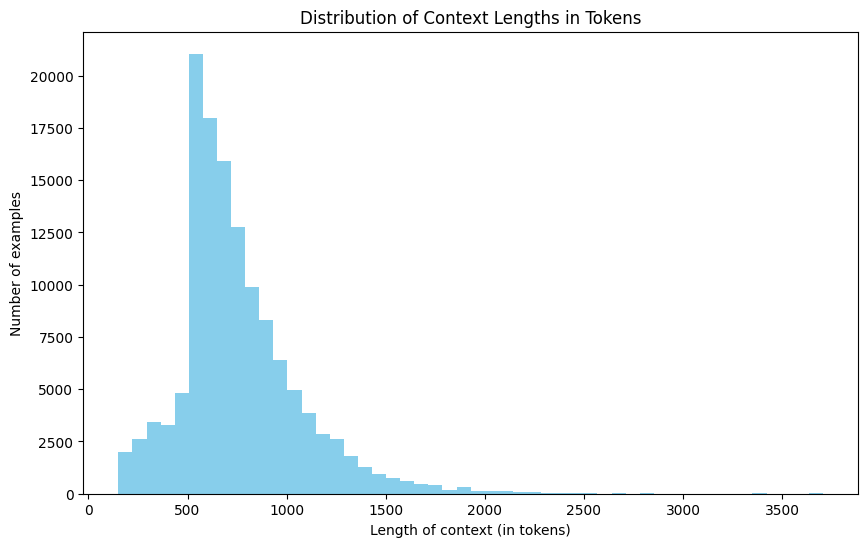

<ipython-input-8-c76a9f697f19>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if row['answers']['text']:


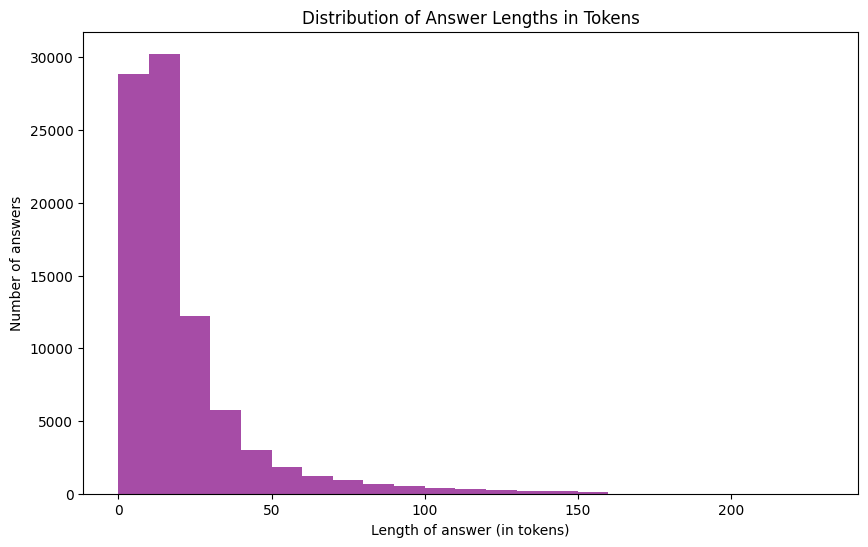

In [9]:
plot_context_and_answer_length_distributions(train)

# Data pre-processing

In [10]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
model = RobertaForQuestionAnswering.from_pretrained("roberta-base")

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trunctuating longer contexts would not work in our case as we might be losing some importants information. We are going to have our samples produce multiple features by splitting them up and allowing for some overlap so we don't split up in the middle of an answer.

In [12]:
max_length = 384  # The maximum length of a feature (in tokens).
doc_stride = 128  # The amount of overlap between features.

In [13]:
pad_on_right = tokenizer.padding_side == "right"

In [14]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [15]:
train_hf = Dataset.from_pandas(train)
validation_hf = Dataset.from_pandas(validation)

train_tokenized = train_hf.map(prepare_train_features, batched=True, remove_columns=train_hf.column_names)
validation_tokenized = validation_hf.map(prepare_train_features, batched=True, remove_columns=train_hf.column_names)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

#Fine-tuning

In [25]:
# Define training arguments

training_args = TrainingArguments(
    "/content/drive/MyDrive/NLP/model",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="tensorboard",
)


# Initialize TensorBoard writer
tensorboard_writer = SummaryWriter(training_args.logging_dir)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.886700,0.897995
2,0.666600,0.846528


Epoch,Training Loss,Validation Loss
1,0.886700,0.897995
2,0.666600,0.846528
3,0.471700,0.957615


ERROR:pyngrok.process.ngrok:t=2024-03-28T16:55:18+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-03-28T16:55:18+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-03-28T16:55:18+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [26]:
trainer.save_model("/content/drive/MyDrive/NLP/models")